In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Örnek veri: seaborn tips
df = sns.load_dataset("tips").copy()
#df = df.rename(columns={"size": "table_size"})
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [65]:
# 1) select (sütun seçimi)
cols = ["total_bill", "tip", "sex", "smoker", "day", "time", "size"]
df_sel = df[cols].copy()
df_sel.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [66]:
# 2) filter (satır filtresi)
df_big = df_sel[(df_sel["total_bill"] > 20) & (df_sel["size"] >= 3)]
df_big.head()

,total_bill,tip,sex,smoker,day,time,size
2,21.01,3.50,Male,No,Sun,Dinner,3
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
7,26.88,3.12,Male,No,Sun,Dinner,4
11,35.26,5.00,Female,No,Sun,Dinner,4


In [67]:
# 3) assign (yeni sütun ekleme)
df_feat = df_big.assign(
    tip_pct=lambda d: d["tip"] / d["total_bill"],
    bill_per_person=lambda d: d["total_bill"] / d["size"]
)
df_feat.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct,bill_per_person
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,7.003333
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,6.147500
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240,6.322500
7,26.88,3.12,Male,No,Sun,Dinner,4,0.116071,6.720000
11,35.26,5.00,Female,No,Sun,Dinner,4,0.141804,8.815000


In [68]:
# 4) groupby().agg (gruplama ve özet)
grp = (df_feat
       .groupby(["day", "smoker"], observed=True)
       .agg(
           tip_pct_mean=("tip_pct", "mean"),
           tip_pct_median=("tip_pct", "median"),
           n=("tip_pct", "size")
       )
       .reset_index())
grp.head()

,day,smoker,tip_pct_mean,tip_pct_median,n
0,Thur,Yes,0.155410,0.155410,2
1,Thur,No,0.144349,0.143999,8
2,Fri,Yes,0.117750,0.117750,1
3,Sat,Yes,0.120622,0.102522,11
4,Sat,No,0.158721,0.156873,11


In [69]:
grp_sorted = grp.sort_values(["tip_pct_mean"], ascending=False)
grp_sorted.head()

,day,smoker,tip_pct_mean,tip_pct_median,n
4,Sat,No,0.158721,0.156873,11
0,Thur,Yes,0.155410,0.155410,2
6,Sun,No,0.149699,0.150000,21
5,Sun,Yes,0.145034,0.136835,6
1,Thur,No,0.144349,0.143999,8


In [70]:
# 6) merge (tablo birleştirme)
# Küçük bir lookup tablosu oluşturalım
lookup = pd.DataFrame({
    "smoker": ["Yes", "No"],
    "smoker_label": ["Smoker", "Non-Smoker"]
})
merged = grp_sorted.merge(lookup, on="smoker", how="left")
merged.head()

,day,smoker,tip_pct_mean,tip_pct_median,n,smoker_label
0,Sat,No,0.158721,0.156873,11,Non-Smoker
1,Thur,Yes,0.155410,0.155410,2,Smoker
2,Sun,No,0.149699,0.150000,21,Non-Smoker
3,Sun,Yes,0.145034,0.136835,6,Smoker
4,Thur,No,0.144349,0.143999,8,Non-Smoker


In [71]:
# 7) pivot_table (geniş tablo)
pv = pd.pivot_table(
    df_feat,
    values="tip_pct",
    index="day",
    columns="smoker",
    aggfunc="mean",
    observed=False
)
pv.head()

smoker,Yes,No
day,,
Thur,0.155410,0.144349
Fri,0.117750,NaN
Sat,0.120622,0.158721
Sun,0.145034,0.149699


In [38]:
# 8) get_dummies (one-hot kodlama)
df_dum = pd.get_dummies(df_sel, columns=["sex", "smoker", "day", "time"], drop_first=True)
df_dum.head()

,total_bill,tip,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,16.99,1.01,2,True,True,False,False,True,True
1,10.34,1.66,3,False,True,False,False,True,True
2,21.01,3.50,3,False,True,False,False,True,True
3,23.68,3.31,2,False,True,False,False,True,True
4,24.59,3.61,4,True,True,False,False,True,True


In [39]:
# Mikro örnek: yüzde bahşiş segmenti oluşturma
df_vec = df.copy()
df_vec["tip_pct"] = df_vec["tip"] / df_vec["total_bill"]

# apply ile (satır bazlı) — genelde daha yavaş
def segment_apply(row):
    return "high" if row["tip_pct"] >= 0.18 else "low"

# Jupyter'de hücre başına kullan: %%timeit
%timeit df_vec["seg_apply"] = df_vec.apply(segment_apply, axis=1)

# Vektörize yaklaşım — hızlı
%timeit df_vec["seg_vec"] = np.where(df_vec["tip_pct"] >= 0.18, "high", "low")

(df_vec["seg_apply"] == df_vec["seg_vec"]).all()

1.49 ms ± 9.42 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
126 μs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


np.True_

In [44]:
# Eksik oranları
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate

total_bill    0.0
tip           0.0
sex           0.0
smoker        0.0
day           0.0
time          0.0
size          0.0
dtype: float64

In [48]:
# Duplikeler
dup_count = df.duplicated().sum()

In [49]:
# Kategorik tip dönüşümü
cat_cols = ["sex", "smoker", "day", "time"]
for c in cat_cols:
    df[c] = df[c].astype("category")

df.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [51]:
date_df = pd.DataFrame({
    "date_str": ["2023-01-01 18:30", "2023-01-02 12:15", "2023-01-03 20:05"]
})
date_df["dt"] = pd.to_datetime(date_df["date_str"])
date_df["dayofweek"] = date_df["dt"].dt.day_name()
date_df["hour"] = date_df["dt"].dt.hour
date_df["minute"] = date_df["dt"].dt.minute
date_df

,date_str,dt,dayofweek,hour,minute
0,2023-01-01 18:30,2023-01-01 18:30:00,Sunday,18,30
1,2023-01-02 12:15,2023-01-02 12:15:00,Monday,12,15
2,2023-01-03 20:05,2023-01-03 20:05:00,Tuesday,20,5


## Doğru grafik seçimi seaborn matplotlib

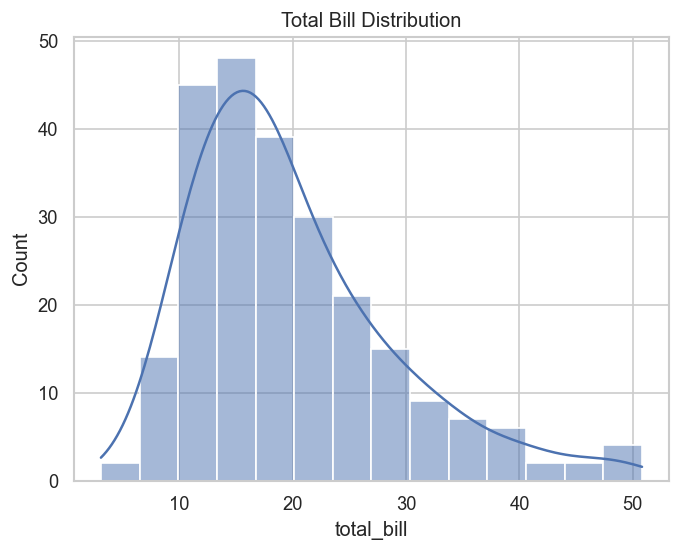

In [52]:
# Sayısal dağılım
sns.histplot(df["total_bill"], kde=True)
plt.title("Total Bill Distribution")
plt.show()

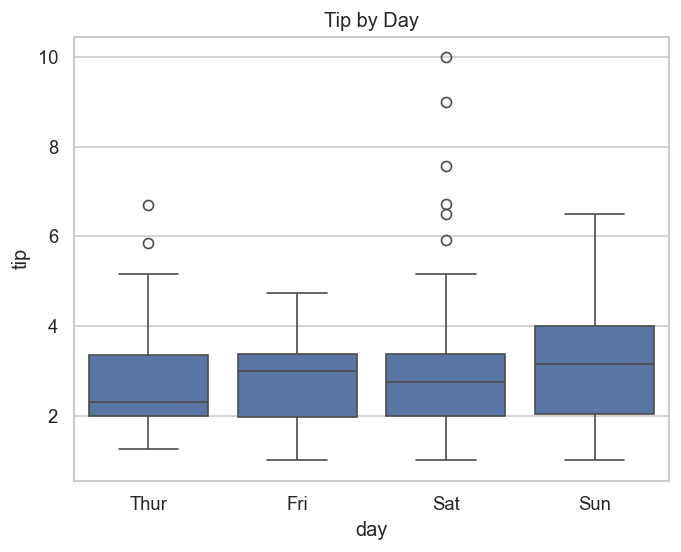

In [53]:
# Kategorik vs sayısal
sns.boxplot(data=df, x="day", y="tip")
plt.title("Tip by Day")
plt.show()

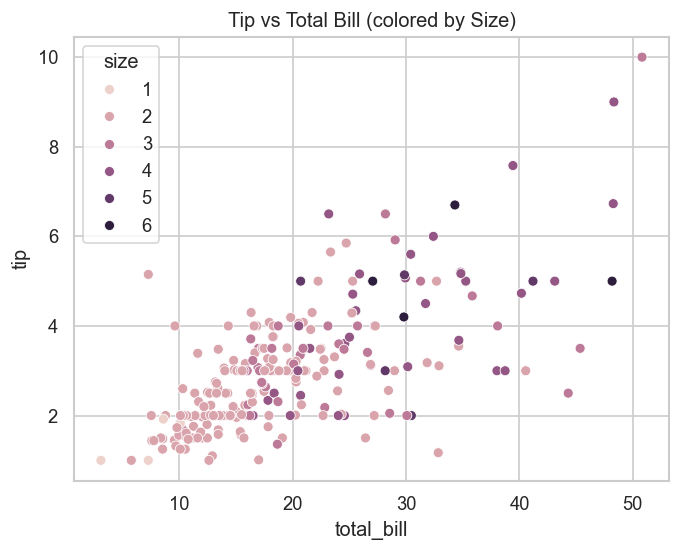

In [54]:
# İki sayısal ilişki (+ hue ile 3. değişken)
sns.scatterplot(data=df, x="total_bill", y="tip", hue="size")
plt.title("Tip vs Total Bill (colored by Size)")
plt.show()

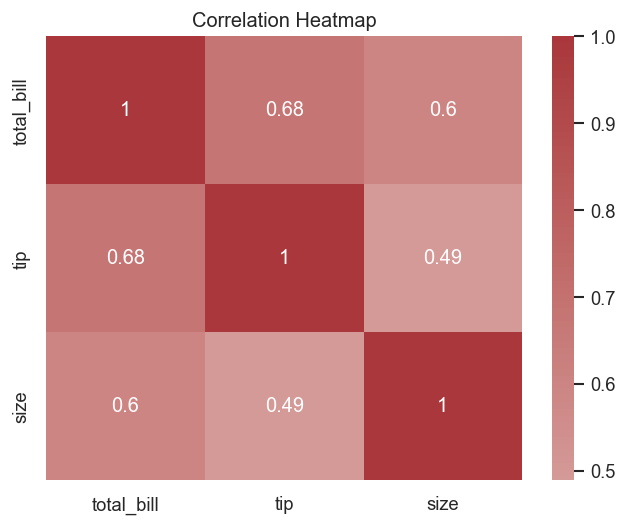

In [57]:
# Korelasyon (sayısal sütunlar)
num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Correlation Heatmap")
plt.show()

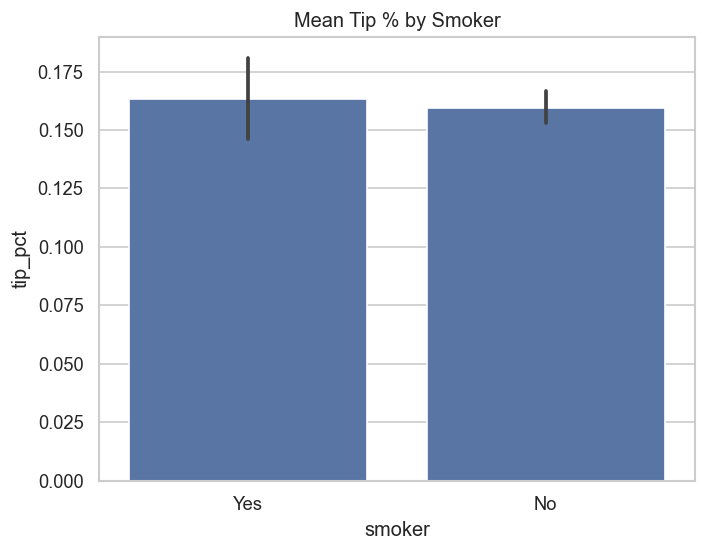

In [59]:
# Kategorik oran/ortalama karşılaştırması (estimator=mean default)
df_tmp = df.copy()
df_tmp["tip_pct"] = df_tmp["tip"] / df_tmp["total_bill"]
sns.barplot(data=df_tmp, x="smoker", y="tip_pct", errorbar=('ci', 95))
plt.title("Mean Tip % by Smoker")
plt.show()

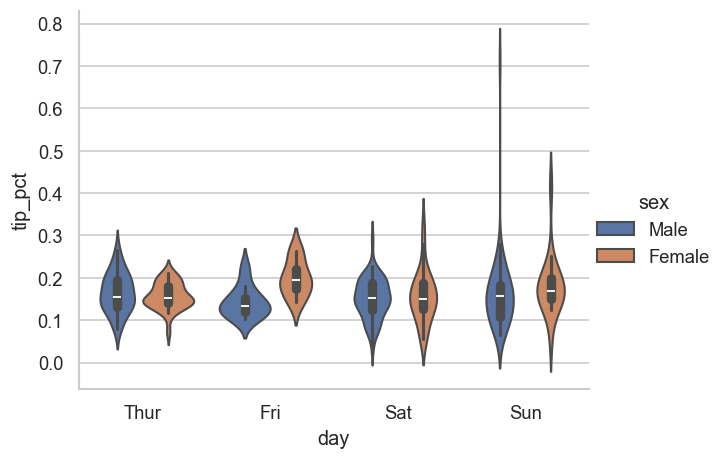

In [60]:
# Çoklu etkileşim (faceting / catplot)
sns.catplot(
    data=df_tmp, x="day", y="tip_pct", hue="sex",
    kind="violin", height=4, aspect=1.3
)
plt.show()